In [25]:
import os
import pandas as pd
import json
import networkx as nx 
import matplotlib.pyplot as plt 
import itertools
import math


In [2]:
output_dir = './UBNormalAlphaPoseOutput'

In [3]:
# Source https://github.com/MVIG-SJTU/AlphaPose/blob/master/docs/output.md
raw_order = [
    {0,  "Nose"},
    {1,  "LEye"},
    {2,  "REye"},
    {3,  "LEar"},
    {4,  "REar"},
    {5,  "LShoulder"},
    {6,  "RShoulder"},
    {7,  "LElbow"},
    {8,  "RElbow"},
    {9,  "LWrist"},
    {10, "RWrist"},
    {11, "LHip"},
    {12, "RHip"},
    {13, "LKnee"},
    {14, "Rknee"},
    {15, "LAnkle"},
    {16, "RAnkle"},
]
order = []
for s in raw_order:
    for item in s:
        if isinstance(item, str):
            order.append(item)
            break

In [13]:
order

['Nose',
 'LEye',
 'REye',
 'LEar',
 'REar',
 'LShoulder',
 'RShoulder',
 'LElbow',
 'RElbow',
 'LWrist',
 'RWrist',
 'LHip',
 'RHip',
 'LKnee',
 'Rknee',
 'LAnkle',
 'RAnkle']

In [7]:
with open('./data/UBnormal/poses/abnormal_scene_8_scenario_5_alphapose_tracked_person.json') as f:
    tracking = json.load(f)

In [24]:
def get_jsons(directory: str):
    """Function that exctracts the mp4 files from the given directory
    and returns the path to the video and it's annotations
    """
    filelist = [];
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.json'):
                json_file = os.path.join(root,file)
                filelist.append(json_file)
    return filelist

In [ ]:
json_files = get_jsons(output_dir)

In [ ]:
# Process pose results jsons
dfs = []
for file in json_files:
    if file.endswith('results.json'):
        df = pd.read_json(file)
        df['video'] = '_'.join(file.split('/')[-1].split('-')[0].split('_')[0:-1])
        if 'abnormal' in file:
            df['label'] = 'abnormal'
        else:
            df['label'] = 'normal'
        df = df[['video', 'image_id', 'label', 'keypoints', 'score']]
        dfs.append(df)
        break
df_overview = pd.concat(dfs, ignore_index=True)

In [ ]:
df_overview.boxplot('score')

In [8]:
key_points = tracking['1']['0000']['keypoints']
converted_keypoints = []
for i in range(0, len(key_points), 3):
    x = key_points[i]
    y = key_points[i+1]
    c = key_points[i+2]
    co = (x,y)
    converted_keypoints.append((co, c))

In [10]:
# Source: https://www.geeksforgeeks.org/visualize-graphs-in-python/
# https://stackoverflow.com/questions/32488772/drawing-nodes-with-coordinates-in-correct-position-using-networkx-matplotlib
class GraphVisualization: 
   
    def __init__(self): 
          
        # visual is a list which stores all  
        # the set of edges that constitutes a 
        # graph 
        self.G = nx.Graph()
          
    # addEdge function inputs the vertices of an 
    # edge and appends it to the visual list 
    def addNode(self, name, pos):
        self.G.add_node(name, pos=(pos[0], -pos[1])) # inverse Y for better representation
    
    def addEdge(self, n1, n2, weight): 
        #self.G.add_edges_from([(n1, n2)])
        self.G.add_edge(n1, n2, weight=weight)
 
    # In visualize function G is an object of 
    # class Graph given by networkx G.add_edges_from(visual) 
    # creates a graph with a given list 
    # nx.draw_networkx(G) - plots the graph 
    # plt.show() - displays the graph 
    def visualize(self): 
        nx.draw_networkx(self.G, nx.get_node_attributes(self.G, 'pos')) 
        # edge_labels = nx.get_edge_attributes(G, "weight")
        # nx.draw_networkx_edge_labels(self.G, nx.get_node_attributes(self.G, 'pos'), edge_labels)        
        plt.show() 

In [11]:
connections = [
    (5,6),
    (5,7),
    (6,8),
    (7,9),
    (8,10),
    (5,11),
    (6,12),
    (11, 12),
    (11,13),
    (12, 14),
    (13, 15),
    (14, 16)
]

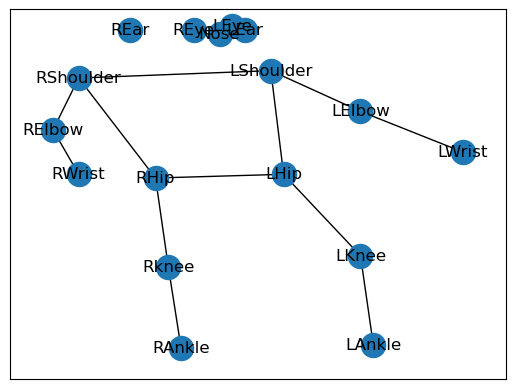

In [12]:
G = GraphVisualization() 
for i, kp in enumerate(converted_keypoints):
    kp_name = order[i]
    G.addNode(kp_name, kp[0])
    # G.addEdge(kp[0], converted_keypoints[i+1][0]) 
for source, target in connections:
    n1 = order[source]
    n2 = order[target]
    co1 = converted_keypoints[source][0]
    co2 = converted_keypoints[target][0]
    weight = math.dist(co1, co2)
    G.addEdge(n1, n2, weight)
G.visualize() 

In [22]:
# Test normalization
def normalize_keypoints(keypoints):
    # Transform 1: Set Nose as origin
    nose_index = order.index('Nose')
    nose_co, _ = keypoints[nose_index]
    tmp_keypoints = []
    for kp in keypoints:
        co, confidence = kp
        adj_x = co[0] - nose_co[0]
        adj_y = co[1] - nose_co[1]
        adj_co = (adj_x, adj_y)
        tmp_keypoints.append((adj_co, confidence))
    # Transofmr 2: Standardize pose size.
    # This is done by setting the distance between the shoulders to 1
    rshoulder_index = order.index('RShoulder')
    lshoulder_index = order.index('LShoulder')
    co1 = keypoints[rshoulder_index][0]
    co2 = keypoints[lshoulder_index][0]
    distance = math.dist(co1, co2)
    normalized_keypoints = []
    for kp in tmp_keypoints:
        co, confidence = kp
        adj_x = co[0]/distance
        adj_y = co[1]/distance
        adj_co = (adj_x, adj_y)
        normalized_keypoints.append((adj_co, confidence))
    return normalized_keypoints
normalized_kp = normalize_keypoints(converted_keypoints)

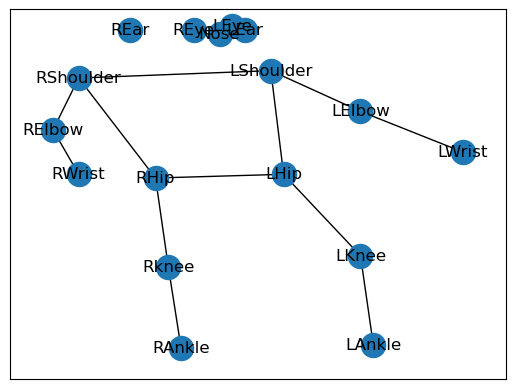

In [23]:
G = GraphVisualization() 
for i, kp in enumerate(normalized_kp):
    kp_name = order[i]
    G.addNode(kp_name, kp[0])
    # G.addEdge(kp[0], converted_keypoints[i+1][0]) 
for source, target in connections:
    n1 = order[source]
    n2 = order[target]
    co1 = converted_keypoints[source][0]
    co2 = converted_keypoints[target][0]
    weight = math.dist(co1, co2)
    G.addEdge(n1, n2, weight)
G.visualize() 

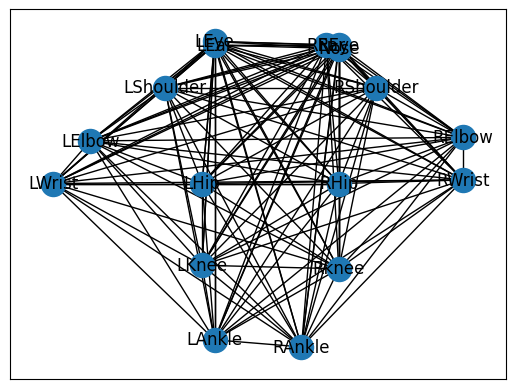

In [61]:
G = GraphVisualization() 
for i, kp in enumerate(converted_keypoints):
    kp_name = order[i]
    G.addNode(kp_name, kp[0])
    # G.addEdge(kp[0], converted_keypoints[i+1][0]) 
for source, target in list(itertools.permutations([i for i in range(0, 17)], 2)):
    n1 = order[source]
    n2 = order[target]
    co1 = converted_keypoints[source][0]
    co2 = converted_keypoints[target][0]
    weight = math.dist(co1, co2)
    G.addEdge(n1, n2, weight)
G.visualize() 